<a href="https://colab.research.google.com/github/SiraDD/Monte-Carlo-Options/blob/main/MyLifesWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [1]:
from IPython.display import clear_output
!pip install easyocr
!pip install python-Levenshtein
clear_output()

# load common libraries
import numpy as np                 # maths
import matplotlib.pyplot as plt    # plotting
import pandas as pd                # data manipulation
from tqdm import tqdm              # loading bar
from time import perf_counter      # timer
import Levenshtein
import cv2
import math
import easyocr
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
! mkdir ~/.kaggle

In [34]:
! cp kaggle.json ~/.kaggle/

In [35]:
! chmod 600 ~/.kaggle/kaggle.json

In [36]:
! kaggle datasets download landlord/handwriting-recognition

 99% 1.24G/1.26G [00:16<00:00, 122MB/s]
100% 1.26G/1.26G [00:16<00:00, 83.5MB/s]


In [ ]:
! unzip handwriting-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_v2/train/TRAIN_86901.jpg  
  inflating: train_v2/train/TRAIN_86902.jpg  
  inflating: train_v2/train/TRAIN_86903.jpg  
  inflating: train_v2/train/TRAIN_86904.jpg  
  inflating: train_v2/train/TRAIN_86905.jpg  
  inflating: train_v2/train/TRAIN_86906.jpg  
  inflating: train_v2/train/TRAIN_86907.jpg  
  inflating: train_v2/train/TRAIN_86908.jpg  
  inflating: train_v2/train/TRAIN_86909.jpg  
  inflating: train_v2/train/TRAIN_86910.jpg  
  inflating: train_v2/train/TRAIN_86911.jpg  
  inflating: train_v2/train/TRAIN_86912.jpg  
  inflating: train_v2/train/TRAIN_86913.jpg  
  inflating: train_v2/train/TRAIN_86914.jpg  
  inflating: train_v2/train/TRAIN_86915.jpg  
  inflating: train_v2/train/TRAIN_86916.jpg  
  inflating: train_v2/train/TRAIN_86917.jpg  
  inflating: train_v2/train/TRAIN_86918.jpg  
  inflating: train_v2/train/TRAIN_86919.jpg  
  inflating: train_v2/train/TRAIN_86920.jpg  
  inflating: train_v2/train/T

In [2]:
def download_image(path):
  original_img = cv2.imread(path)
  return original_img

In [3]:
def process_img(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)
  _, thresholded = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY)
  canny = cv2.Canny(thresholded, 0, 230)
  return gray, blur, thresholded, canny

In [4]:
def find_contours(canny):
  contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours

In [5]:
def filter_contours(contours):
  filtered_contours = []
  for contour in contours:
    if cv2.contourArea(contour) >= 2:
      filtered_contours.append(contour)
  return filtered_contours

In [6]:
def draw_contours(original_img, filtered_contours):
  for index, contour in enumerate(filtered_contours):
    contour_img = cv2.drawContours(original_img, filtered_contours, index, (0, 255, 0), 2)
    area = cv2.contourArea(contour)
    #print('Contour Area:', area)
    cv2_imshow(contour_img)
  return contour_img

In [7]:
def draw_and_store_rectangles_coordinates(original_img, filtered_contours):
  coordinatesRectangles = []
  for index, contour in enumerate(filtered_contours):
    x, y, width, height = cv2.boundingRect(contour) # this returns the coordinates of the top left corner
    box = [[x, y], [x, y + height], [x + width, y + height], [x + width, y]]
    box = np.int0(box)
    coordinatesRectangles.append(box)
    rectangle_img = cv2.drawContours(original_img, [box], 0, (0, 255, 0), 3)
  coordinatesRectangles.sort(key=lambda coord: coord[0][0])
  return coordinatesRectangles, rectangle_img

In [8]:
def cut_letters(gray, coordinatesRectangles, size):
  cut_letters_list = []
  for index in range(len(coordinatesRectangles)):
    cut_letter = gray[coordinatesRectangles[index][0][1]:coordinatesRectangles[index][1][1], coordinatesRectangles[index][0][0]:coordinatesRectangles[index][2][0]]
    white_background = np.ones((size, size)) * 255 
    if len(cut_letter) > size or cut_letter.shape[1] > 32:
      continue
    # determine the x,y - coordinates of the top-left corner of where the image will be pasted
    x = 0
    y = 0
    white_background[y:y + cut_letter.shape[0], x:x + cut_letter.shape[1]] = cut_letter
    cv2_imshow(white_background)
    cut_letters_list.append(cut_letter)
  return cut_letters_list


In [9]:
def first_cut(text_reader, uncut_img, word):
  results = text_reader.readtext(uncut_img)
  lowestDistance = 1000
  lowestIndex = 0
  lowestName = ''
  isDigital = False
  for index, (bbox, text, prob) in enumerate(results):
    text = text.replace(' ', '').upper()
    #print(text)
    #print(Levenshtein.distance(word, text)/len(text))
    if Levenshtein.distance(word, text)/len(text) < lowestDistance:
      lowestDistance = Levenshtein.distance(word, text)/len(text)
      lowestIndex = index
      lowestName = text
  if 'NOM' in lowestName:
      isDigital = True
  if len(results) == 0:
    original_img = uncut_img
    img = uncut_img
    lowestName = ''
    isDigital = True
  else:
    box = results[lowestIndex][0]
    box = np.int0(box)
    original_img = uncut_img[box[0][1]:box[2][1], box[0][0]:box[1][0]]
    cv2_imshow(original_img)
    img = original_img
  return original_img, img, lowestName, isDigital

In [14]:
def obtain_train_data(path):
  data_frame = pd.read_excel(path)
  #data_frame = pd.read_csv(path)
  data_array = data_frame.to_numpy()
  words = []
  paths = []
  for i in range(len(data_array)):
    words.append(data_array[i][1])
    paths.append(data_array[i][0])
  text_reader = easyocr.Reader(['en'])
  cut_letters_overall = []
  used_letters_overall = []
  for i in range(len(data_array)):
    contains_nom = False
    uncut_img = download_image(paths[i])
    cv2_imshow(uncut_img)
    original_img, img, prediction_name, contains_nom = first_cut(text_reader, uncut_img, words[i])
    if len(prediction_name) != len(words[i]):
      continue
    elif contains_nom:
      continue
    gray, blur, thresholded, canny = process_img(img)
    cv2_imshow(img)
    cv2_imshow(gray)
    cv2_imshow(blur)
    cv2_imshow(thresholded)
    cv2_imshow(canny)
    contours = find_contours(canny)
    filtered_contours = filter_contours(contours)
    #print(len(filtered_contours))
    #for contour in contours:
      #print('Contour Area:', cv2.contourArea(contour))
    contour_img = draw_contours(original_img, filtered_contours)
    cv2_imshow(contour_img)
    original_img = img
    coordinatesRectangles, rectangle_img = draw_and_store_rectangles_coordinates(original_img, filtered_contours)
    cv2_imshow(rectangle_img)
    cut_letters_list = cut_letters(gray, coordinatesRectangles, 32)
    characters = [char for char in words[i]]
    #print('CHARACTERS LENGTH: ' + str(len(characters)))
    #print(characters)
    if len(cut_letters_list) == len(characters):
      for i in range(len(cut_letters_list)):
        cut_letters_overall.append(cut_letters_list[i])
        used_letters_overall.append(characters[i])
  return used_letters_overall, cut_letters_overall

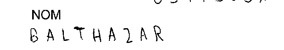

NOM
3.0
84LTHA2AR
0.3333333333333333


Contour Area: 100.5


Contour Area: 54.5


Contour Area: 80.0


Contour Area: 80.0


Contour Area: 76.0


Contour Area: 2.0


Contour Area: 128.0


Contour Area: 79.0


Contour Area: 128.0


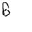

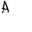

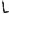

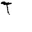

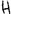

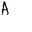

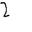

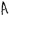

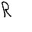

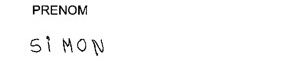

PRENOM
0.8333333333333334
5IMON
0.2


Contour Area: 150.5


Contour Area: 126.5


Contour Area: 5.0


Contour Area: 4.0


Contour Area: 61.5


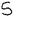

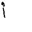

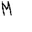

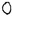

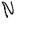

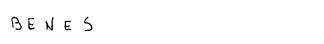

0ENE$
0.4


Contour Area: 72.0


Contour Area: 85.0


Contour Area: 3.0


Contour Area: 86.5


Contour Area: 5.5


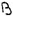

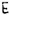

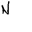

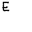

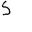

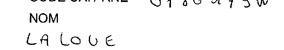

NOM
2.0
LALOU€
0.5


"PRENOM:
0.875
0APHNE
0.16666666666666666


Contour Area: 2.0


Contour Area: 7.0


Contour Area: 115.5


Contour Area: 137.5


Contour Area: 5.5


Contour Area: 116.5


Contour Area: 6.5


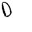

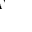

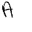

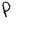

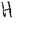

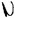

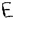

U(
2.0


DRENOM=
0.8571428571428571


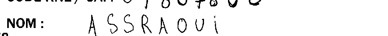

0"70
2.0
NOM
2.3333333333333335
SSRA0U
0.5


ERENOM
1.0
LH
2.5
V8AV
1.0


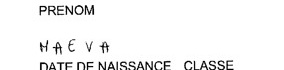

PRENOM
0.8333333333333334
HA€
1.3333333333333333
DATFOFNAISEANCF
0.8666666666666667
CLASSE
0.8333333333333334
V#
2.0


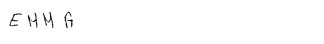

EHH
1.0


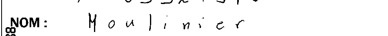

NOM:
2.0


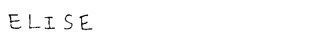

ELISE
0.0


Contour Area: 85.0


Contour Area: 2.0


Contour Area: 123.0


Contour Area: 86.5


Contour Area: 5.5


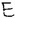

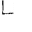

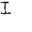

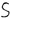

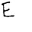

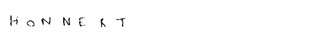

1+N
2.0
N[
3.0
6T
3.0


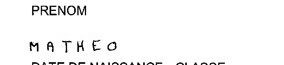

PRENOM
1.0
M0THE0
0.3333333333333333


Contour Area: 97.5


Contour Area: 6.5


Contour Area: 2.0


Contour Area: 82.0


Contour Area: 65.5


Contour Area: 89.5


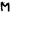

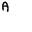

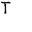

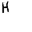

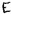

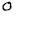

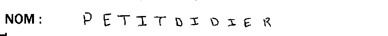

NOM
3.6666666666666665
ETIT0I
1.0
0IER
2.0


LIN
1.3333333333333333


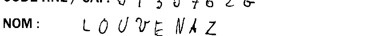

NOM
2.3333333333333335
L0UTENAZ
0.25


Contour Area: 3.5


Contour Area: 4.0


Contour Area: 4.5


Contour Area: 2.5


Contour Area: 56.5


Contour Area: 78.5


Contour Area: 3.0


Contour Area: 140.5


Contour Area: 9.0


Contour Area: 5.5


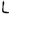

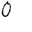

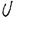

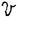

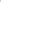

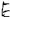

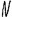

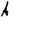

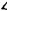

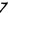

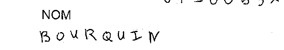

NOM
2.3333333333333335
10URQUI@
0.375


Contour Area: 106.5


Contour Area: 99.5


Contour Area: 75.5


Contour Area: 76.0


Contour Area: 59.5


Contour Area: 3.0


Contour Area: 10.0


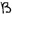

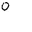

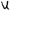

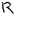

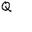

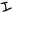

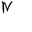

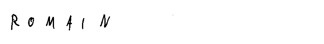

R0M4(N
0.5


Contour Area: 36.0


Contour Area: 92.0


Contour Area: 72.0


Contour Area: 66.0


Contour Area: 103.0


Contour Area: 113.5


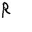

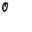

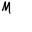

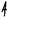

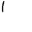

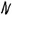

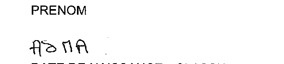

PRENOM
1.0
931A
0.75


Contour Area: 3.5


Contour Area: 7.0


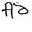

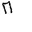

R;ELLE
0.5
CY
3.0


LILOU
0.0


Contour Area: 51.0


Contour Area: 2.0


Contour Area: 84.5


Contour Area: 130.0


Contour Area: 80.5


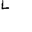

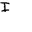

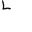

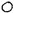

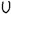

GRENOM
1.1666666666666667
€S+2B
1.2
7N
3.5


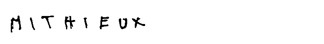

0IT#|FUK
0.625


Contour Area: 99.0


Contour Area: 108.5


Contour Area: 47.0


Contour Area: 52.0


Contour Area: 122.5


Contour Area: 129.5


Contour Area: 98.0


Contour Area: 137.0


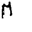

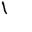

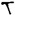

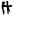

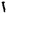

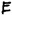

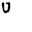

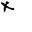

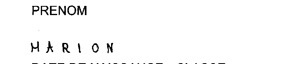

PRENOM
0.8333333333333334
H*R|0N
0.6666666666666666


Contour Area: 76.5


Contour Area: 35.0


Contour Area: 80.0


Contour Area: 88.0


Contour Area: 76.5


Contour Area: 4.5


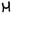

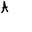

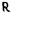

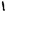

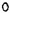

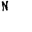

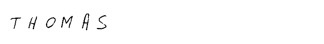

TH0MA$
0.3333333333333333


Contour Area: 104.0


Contour Area: 79.0


Contour Area: 106.0


Contour Area: 62.0


Contour Area: 81.0


Contour Area: 109.5


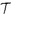

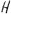

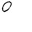

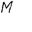

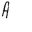

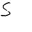

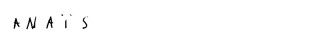

4N^;$
0.8


Contour Area: 28.5


Contour Area: 60.0


Contour Area: 50.5


Contour Area: 6.0


Contour Area: 71.5


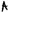

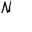

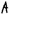

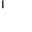

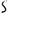

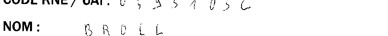

NOM
1.3333333333333333


14FFEUX
0.2857142857142857


Contour Area: 77.0


Contour Area: 81.5


Contour Area: 63.0


Contour Area: 55.5


Contour Area: 4.5


Contour Area: 46.5


Contour Area: 81.5


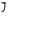

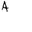

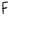

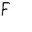

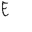

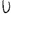

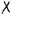

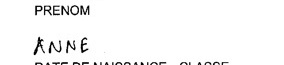

PRENOM
0.8333333333333334
KNNE
0.25


Contour Area: 129.5


Contour Area: 5.5


Contour Area: 13.0


Contour Area: 138.5


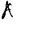

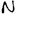

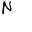

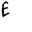

PR€V0$T
0.42857142857142855


Contour Area: 87.5


Contour Area: 64.5


Contour Area: 7.0


Contour Area: 85.5


Contour Area: 68.5


Contour Area: 82.5


Contour Area: 5.0


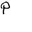

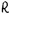

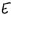

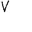

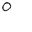

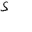

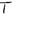

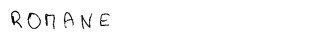

ANE
1.0
RON
1.0


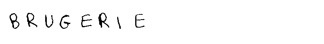

8RUGER|E
0.25


Contour Area: 42.5


Contour Area: 5.5


Contour Area: 2.5


Contour Area: 131.0


Contour Area: 3.5


Contour Area: 141.5


Contour Area: 129.5


Contour Area: 141.5


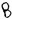

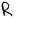

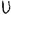

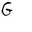

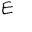

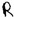

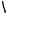

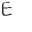

ERENOM
1.0
N0LAN
0.2


Contour Area: 73.5


Contour Area: 2.5


Contour Area: 155.5


Contour Area: 2.0


Contour Area: 2.5


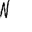

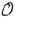

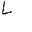

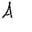

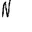

(0RENT'N
0.375


Contour Area: 20.0


Contour Area: 74.0


Contour Area: 3.5


Contour Area: 2.5


Contour Area: 4.5


Contour Area: 86.5


Contour Area: 49.5


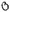

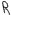

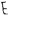

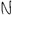

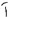

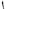

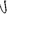

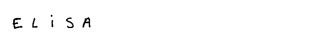

ELI$A
0.2


Contour Area: 26.0


Contour Area: 49.0


Contour Area: 79.0


Contour Area: 9.0


Contour Area: 104.5


Contour Area: 4.0


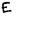

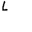

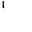

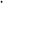

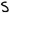

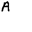

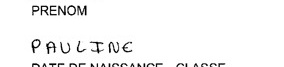

PRENOM
1.0
PAULTNC
0.2857142857142857


Contour Area: 87.0


Contour Area: 5.0


Contour Area: 84.5


Contour Area: 7.5


Contour Area: 116.5


Contour Area: 2.0


Contour Area: 118.5


Contour Area: 5.5


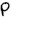

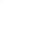

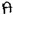

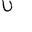

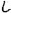

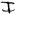

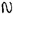

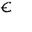

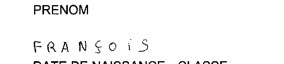

PRENOM
0.8333333333333334
FQAN$0IS
0.375


Contour Area: 16.0


Contour Area: 70.0


Contour Area: 65.5


Contour Area: 4.0


Contour Area: 82.5


Contour Area: 58.5


Contour Area: 71.0


Contour Area: 68.0


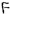

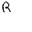

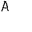

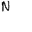

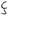

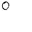

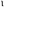

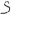

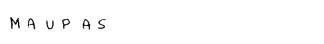

MA
2.0
UP
2.0
A$
2.5


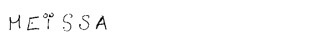

HE?$SA
0.5


Contour Area: 107.5


Contour Area: 105.5


Contour Area: 101.0


Contour Area: 8.0


Contour Area: 19.5


Contour Area: 4.5


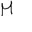

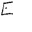

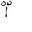

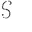

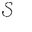

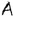

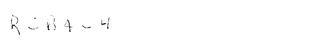

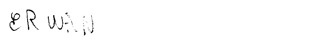

ERUJ;;
0.6666666666666666


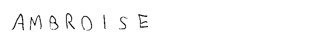

AM8R0|$E
0.5


Contour Area: 3.0


Contour Area: 4.0


Contour Area: 37.5


Contour Area: 100.0


Contour Area: 93.5


Contour Area: 3.5


Contour Area: 122.0


Contour Area: 123.5


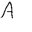

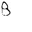

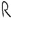

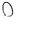

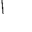

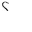

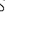

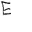

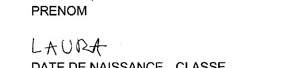

PRENOM
1.0
LTUNT
0.6
CTNEA
0.8
RCC
1.6666666666666667


Contour Area: 3.0


Contour Area: 100.0


Contour Area: 97.0


Contour Area: 15.0


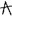

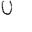

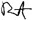

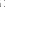

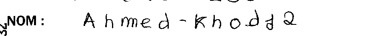

AHME&
1.6
KH0DD2
1.5
SNOM
2.75


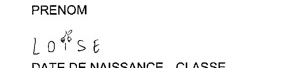

PRENOM
1.0
L0
2.0
YS&
1.3333333333333333
ECAA
1.25


ELBAKKAL
0.125


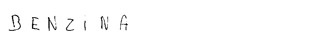

DEN2(WG
0.7142857142857143


Contour Area: 28.5


Contour Area: 9.5


Contour Area: 88.5


Contour Area: 88.0


Contour Area: 84.5


Contour Area: 5.5


Contour Area: 159.5


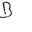

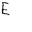

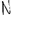

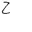

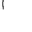

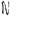

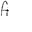

A0U€
2.25
RR
4.5
6R€
3.3333333333333335


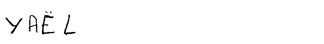

YAEL
0.0


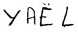

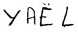

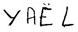

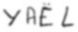

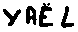

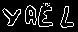

Contour Area: 134.5


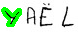

Contour Area: 2.5


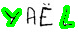

Contour Area: 4.0


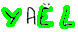

Contour Area: 156.0


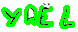

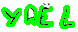

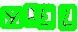

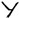

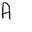

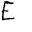

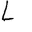

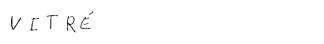

V[TRE
0.2


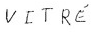

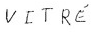

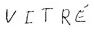

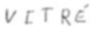

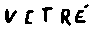

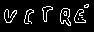

Contour Area: 3.0


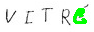

Contour Area: 3.5


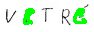

Contour Area: 7.0


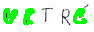

Contour Area: 121.5


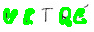

Contour Area: 65.0


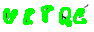

Contour Area: 10.0


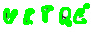

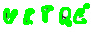

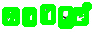

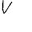

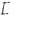

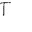

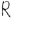

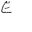

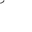

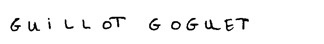

6UI
4.0
LL6T
2.75
60GLET
1.8333333333333333


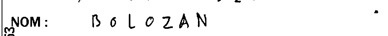

NOM
2.0
06L
2.0
024N
1.5


NATH€6
0.5


Contour Area: 40.0


Contour Area: 91.5


Contour Area: 80.0


Contour Area: 115.0


Contour Area: 7.0


Contour Area: 128.5


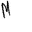

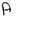

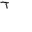

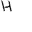

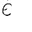

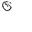

SHA
0.6666666666666666


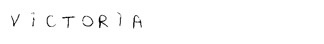

V:€TOR|A
0.375


Contour Area: 25.0


Contour Area: 64.5


Contour Area: 8.5


Contour Area: 121.0


Contour Area: 5.0


Contour Area: 61.5


Contour Area: 105.0


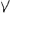

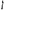

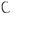

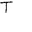

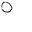

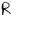

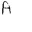

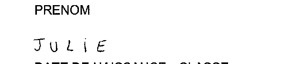

PRENOM
1.0
JULI€
0.2


Contour Area: 31.0


Contour Area: 2.0


Contour Area: 54.0


Contour Area: 4.5


Contour Area: 4.0


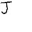

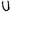

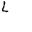

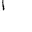

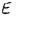

PARPIEA
0.42857142857142855


Contour Area: 4.0


Contour Area: 113.0


Contour Area: 80.0


Contour Area: 86.5


Contour Area: 3.5


Contour Area: 82.5


Contour Area: 3.0


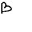

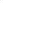

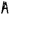

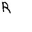

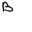

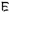

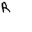

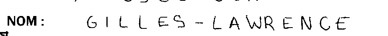

NOM
4.666666666666667
6|LLES
1.8333333333333333
LAWR€N€€
1.25


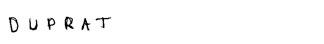

DUPR^T
0.16666666666666666


Contour Area: 94.0


Contour Area: 86.5


Contour Area: 88.5


Contour Area: 94.0


Contour Area: 124.5


Contour Area: 158.0


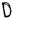

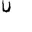

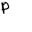

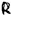

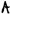

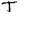

LE8A0H
0.5


Contour Area: 112.0


Contour Area: 102.0


Contour Area: 71.0


Contour Area: 106.0


Contour Area: 145.0


Contour Area: 110.0


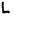

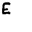

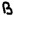

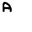

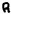

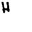

CM
1.5


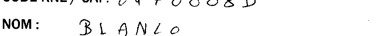

NOM:
1.5
N2
2.5


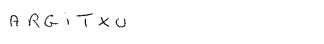

0RG'7XU
0.42857142857142855


Contour Area: 69.0


Contour Area: 24.5


Contour Area: 19.0


Contour Area: 68.5


Contour Area: 4.5


Contour Area: 2.5


Contour Area: 9.5


Contour Area: 2.0


Contour Area: 7.0


Contour Area: 2.5


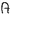

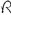

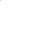

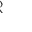

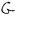

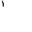

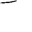

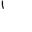

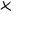

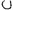

S|NEM
0.2


Contour Area: 2.5


Contour Area: 92.0


Contour Area: 70.0


Contour Area: 3.5


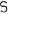

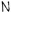

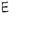

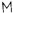

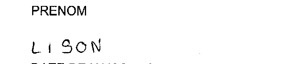

PRENOM
0.8333333333333334
LISON
0.0


Contour Area: 20.0


Contour Area: 34.0


Contour Area: 66.5


Contour Area: 11.0


Contour Area: 5.5


Contour Area: 123.0


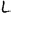

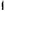

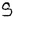

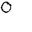

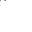

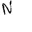

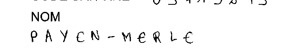

NOM
3.0
PAY€N
1.4
M€RL€
1.6


PRENOM
0.8333333333333334
INCS
0.25


Contour Area: 83.0


Contour Area: 85.5


Contour Area: 121.0


Contour Area: 10.0


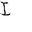

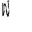

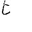

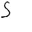

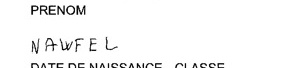

PRENOM
1.0
NAWF
0.5
EL
2.0


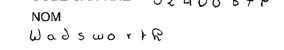

NOM
2.6666666666666665
LU0
3.0


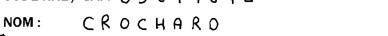

NOM
2.3333333333333335
CR0(HAR0
0.375


Contour Area: 101.0


Contour Area: 86.5


Contour Area: 135.5


Contour Area: 109.5


Contour Area: 115.0


Contour Area: 113.0


Contour Area: 103.5


Contour Area: 139.0


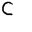

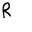

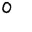

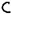

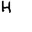

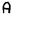

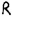

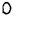

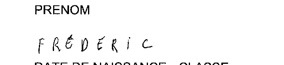

PRENOM
1.0
FR60€6|€
0.75


Contour Area: 63.5


Contour Area: 73.0


Contour Area: 101.0


Contour Area: 65.5


Contour Area: 26.5


Contour Area: 70.0


Contour Area: 94.0


Contour Area: 98.5


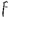

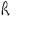

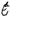

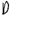

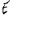

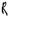

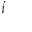

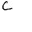

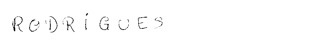

RE)RIGVE$
0.4444444444444444


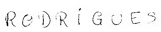

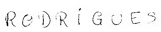

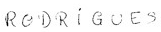

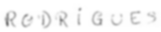

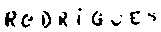

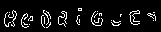

Contour Area: 2.5


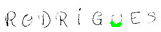

Contour Area: 5.5


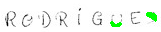

Contour Area: 3.5


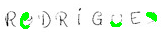

Contour Area: 2.0


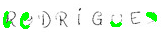

Contour Area: 2.5


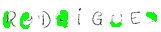

Contour Area: 2.0


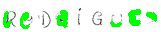

Contour Area: 3.0


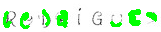

Contour Area: 3.0


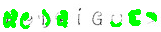

Contour Area: 6.0


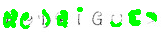

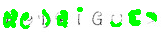

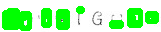

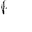

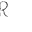

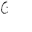

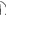

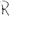

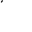

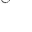

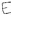

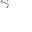

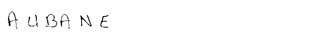

04BNNE
0.5


Contour Area: 3.0


Contour Area: 31.0


Contour Area: 78.5


Contour Area: 104.0


Contour Area: 6.0


Contour Area: 13.5


Contour Area: 5.0


Contour Area: 5.5


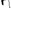

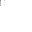

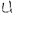

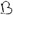

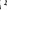

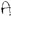

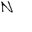

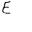

ELI$A
0.2


Contour Area: 27.5


Contour Area: 69.5


Contour Area: 124.0


Contour Area: 103.5


Contour Area: 7.5


Contour Area: 4.0


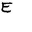

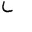

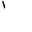

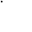

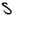

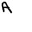

A€HOVR
0.5


#RENOM
0.8333333333333334
M0€
1.3333333333333333


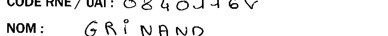

CUDEANC
0.7142857142857143
UAI:
1.5
06
3.5
404-
1.75
NOM
2.0
GR8
1.6666666666666667
VANO
1.25


Contour Area: 5.5


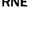

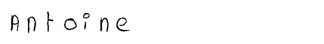

A0}0?NE
0.5714285714285714


Contour Area: 152.5


Contour Area: 117.5


Contour Area: 159.0


Contour Area: 3.0


Contour Area: 5.0


Contour Area: 78.0


Contour Area: 91.0


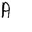

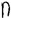

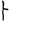

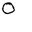

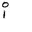

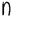

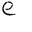

IPRENOM
0.8571428571428571
54NI
0.75


Contour Area: 126.5


Contour Area: 2.5


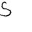

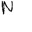

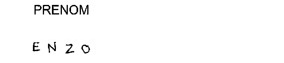

PRENOM
0.6666666666666666
EN20
0.5


Contour Area: 85.5


Contour Area: 80.0


Contour Area: 4.0


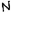

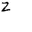

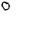

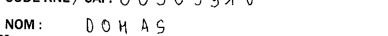

NOM
1.0
00H
1.6666666666666667
45
2.5


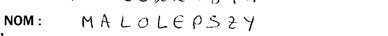

NOM
3.0
M4LOLE0$2Y
0.4


Contour Area: 10.0


Contour Area: 84.5


Contour Area: 109.0


Contour Area: 59.5


Contour Area: 72.0


Contour Area: 110.0


Contour Area: 6.0


Contour Area: 9.5


Contour Area: 5.5


Contour Area: 3.5


Contour Area: 90.5


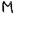

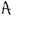

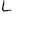

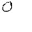

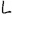

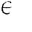

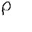

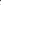

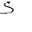

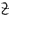

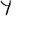

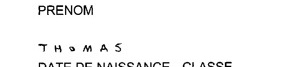

PRENOM
1.0
MA
2.0
74>
2.0


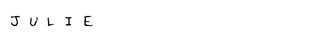

JULIE
0.0


Contour Area: 40.0


Contour Area: 4.0


Contour Area: 56.5


Contour Area: 81.5


Contour Area: 81.5


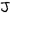

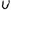

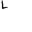

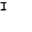

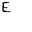

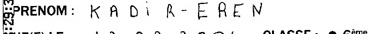

EPRENOM
1.1428571428571428
KA0IR-EAEN
0.3


Contour Area: 12.0


Contour Area: 26.0


Contour Area: 7.0


Contour Area: 6.0


Contour Area: 7.0


Contour Area: 114.0


Contour Area: 107.0


Contour Area: 99.0


Contour Area: 94.0


Contour Area: 4.5


Contour Area: 4.5


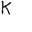

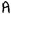

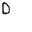

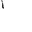

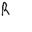

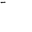

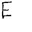

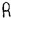

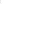

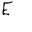

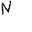

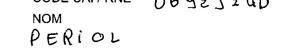

U0J2
1.5
NOM
1.6666666666666667
PERI0L
0.16666666666666666


Contour Area: 66.5


Contour Area: 5.0


Contour Area: 126.0


Contour Area: 49.0


Contour Area: 164.5


Contour Area: 142.5


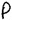

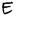

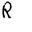

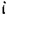

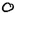

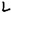

BAGEAU
0.3333333333333333


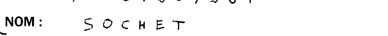

NOM:
1.25
50(HE
0.8


TRQV
1.0
LAK
2.0


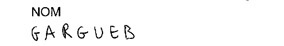

NOM
2.3333333333333335
GARGUEB
0.0


Contour Area: 83.0


Contour Area: 112.0


Contour Area: 103.0


Contour Area: 3.0


Contour Area: 101.0


Contour Area: 142.5


Contour Area: 123.0


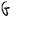

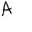

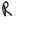

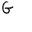

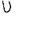

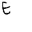

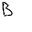

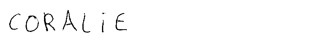

CORALI€
0.14285714285714285


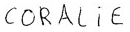

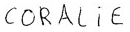

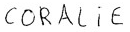

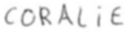

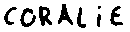

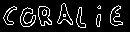

Contour Area: 37.0


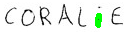

Contour Area: 81.5


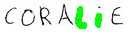

Contour Area: 137.0


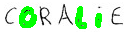

Contour Area: 178.5


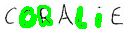

Contour Area: 83.5


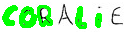

Contour Area: 117.5


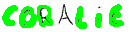

Contour Area: 6.0


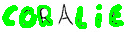

Contour Area: 142.5


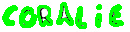

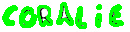

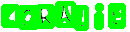

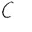

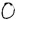

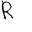

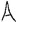

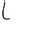

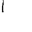

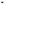

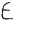

VAN$ENAAE€LE
0.25


Contour Area: 2.0


Contour Area: 2.5


Contour Area: 48.0


Contour Area: 73.5


Contour Area: 108.5


Contour Area: 5.0


Contour Area: 3.5


Contour Area: 91.5


Contour Area: 2.5


Contour Area: 4.0


Contour Area: 80.5


Contour Area: 2.0


Contour Area: 87.5


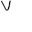

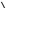

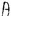

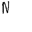

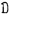

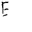

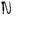

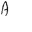

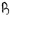

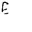

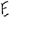

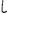

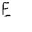

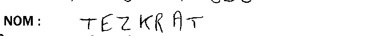

NOM
2.3333333333333335
TEZKRAT
0.0


Contour Area: 91.5


Contour Area: 2.0


Contour Area: 3.0


Contour Area: 6.5


Contour Area: 7.5


Contour Area: 130.0


Contour Area: 5.0


Contour Area: 156.0


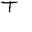

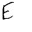

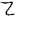

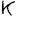

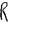

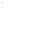

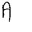

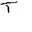

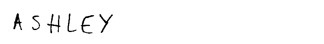

4S#LEY
0.3333333333333333


Contour Area: 126.0


Contour Area: 147.0


Contour Area: 156.5


Contour Area: 91.5


Contour Area: 87.5


Contour Area: 115.0


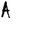

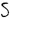

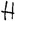

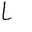

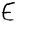

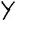

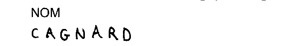

NOM
2.0
CAGNARD
0.0


Contour Area: 5.0


Contour Area: 119.5


Contour Area: 90.5


Contour Area: 2.0


Contour Area: 6.0


Contour Area: 6.0


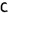

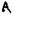

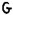

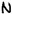

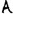

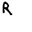

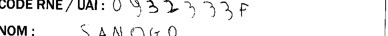

CODERNE
1.0
UAI:U93))3
0.9
VOM:
1.25


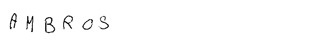

0M8R0$
0.8333333333333334


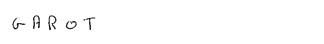

60ROT
0.4


Contour Area: 2.5


Contour Area: 99.5


Contour Area: 8.0


Contour Area: 5.0


Contour Area: 69.5


Contour Area: 4.0


Contour Area: 8.5


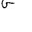

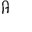

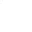

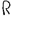

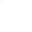

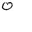

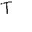

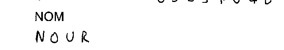

NOM
0.6666666666666666
N0UR
0.25


Contour Area: 5.0


Contour Area: 94.5


Contour Area: 85.0


Contour Area: 6.5


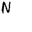

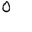

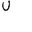

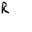

#RENOM
1.3333333333333333
T/H
2.0
0T
3.5
H€E
2.0


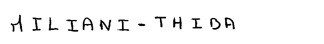

AILIANI-THIOA
0.15384615384615385


Contour Area: 28.5


Contour Area: 5.0


Contour Area: 106.0


Contour Area: 103.0


Contour Area: 77.0


Contour Area: 5.5


Contour Area: 136.0


Contour Area: 91.5


Contour Area: 131.5


Contour Area: 99.0


Contour Area: 83.5


Contour Area: 118.0


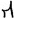

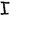

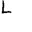

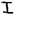

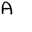

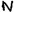

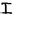

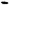

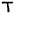

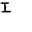

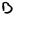

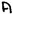

THE0
0.25


Contour Area: 84.5


Contour Area: 86.5


Contour Area: 146.5


Contour Area: 126.5


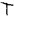

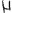

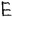

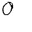

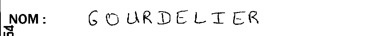

NOM:
2.25
0URDELIER
0.2222222222222222


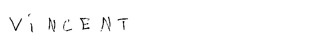

VIWCENT
0.14285714285714285


Contour Area: 30.0


Contour Area: 49.5


Contour Area: 91.0


Contour Area: 84.5


Contour Area: 63.0


Contour Area: 4.5


Contour Area: 91.0


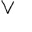

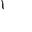

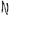

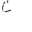

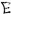

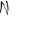

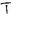

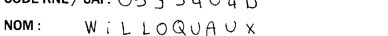

NOM
3.0
L0QUAU
0.8333333333333334


1OVI5
0.4


Contour Area: 5.0


Contour Area: 79.5


Contour Area: 5.0


Contour Area: 68.5


Contour Area: 47.5


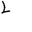

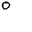

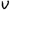

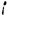

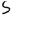

VEA$T04@T€
0.6


Contour Area: 52.0


Contour Area: 79.0


Contour Area: 46.5


Contour Area: 54.0


Contour Area: 83.5


Contour Area: 81.5


Contour Area: 84.0


Contour Area: 4.5


Contour Area: 83.5


Contour Area: 2.5


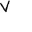

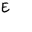

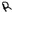

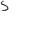

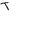

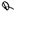

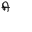

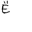

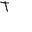

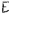

PRENOM:
0.8571428571428571
STNDI
0.2


Contour Area: 123.5


Contour Area: 4.0


Contour Area: 3.0


Contour Area: 169.0


Contour Area: 125.0


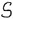

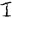

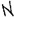

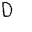

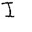

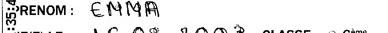

RENOM:
0.6666666666666666
ENMA
0.25


Contour Area: 6.0


Contour Area: 5.0


Contour Area: 8.5


Contour Area: 4.0


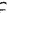

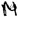

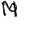

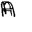

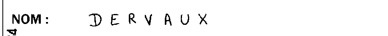

NOM
2.3333333333333335
DERVAUX
0.0


Contour Area: 81.0


Contour Area: 77.5


Contour Area: 3.0


Contour Area: 89.0


Contour Area: 4.0


Contour Area: 85.0


Contour Area: 152.0


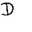

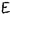

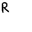

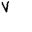

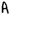

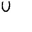

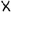

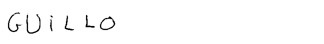

GUILLO
0.0


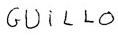

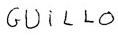

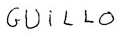

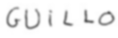

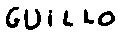

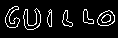

Contour Area: 194.5


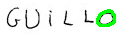

Contour Area: 74.5


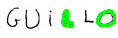

Contour Area: 73.5


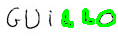

Contour Area: 50.0


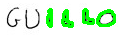

Contour Area: 161.0


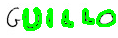

Contour Area: 141.0


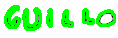

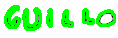

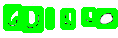

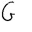

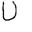

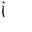

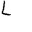

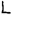

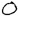

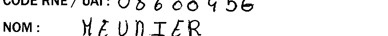

U0
3.0
00
3.5
406
2.3333333333333335
NOM
2.3333333333333335
H/UNIER
0.42857142857142855


Contour Area: 2.0


Contour Area: 14.5


Contour Area: 3.0


Contour Area: 3.0


Contour Area: 3.0


Contour Area: 7.0


Contour Area: 6.5


Contour Area: 2.0


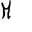

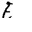

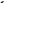

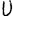

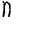

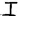

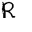

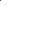

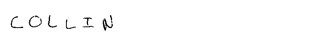

COLLIN
0.0


Contour Area: 52.0


Contour Area: 73.0


Contour Area: 79.0


Contour Area: 4.5


Contour Area: 62.0


Contour Area: 151.0


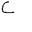

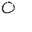

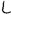

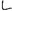

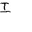

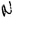

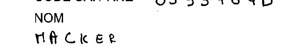

NOM
2.0
NACK€
0.6


PRENOM
1.1666666666666667
R4P
1.6666666666666667
#AE
1.6666666666666667


FER0N
0.2


Contour Area: 91.5


Contour Area: 62.0


Contour Area: 83.5


Contour Area: 65.5


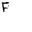

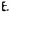

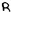

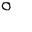

DAVMESN;
0.375


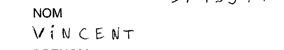

NOM
2.0
VIW(ENT
0.2857142857142857


Contour Area: 31.5


Contour Area: 55.0


Contour Area: 4.5


Contour Area: 58.5


Contour Area: 2.5


Contour Area: 84.5


Contour Area: 90.5


Contour Area: 10.0


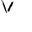

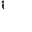

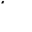

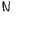

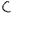

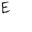

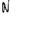

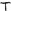

B0VTE1
0.5


Contour Area: 2.5


Contour Area: 79.5


Contour Area: 59.0


Contour Area: 68.0


Contour Area: 93.5


Contour Area: 6.0


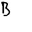

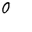

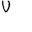

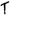

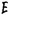

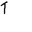

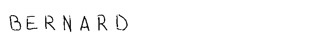

BERN4RD
0.14285714285714285


Contour Area: 106.0


Contour Area: 3.0


Contour Area: 134.5


Contour Area: 3.5


Contour Area: 184.5


Contour Area: 143.0


Contour Area: 180.5


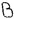

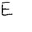

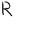

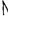

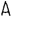

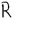

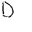

BZNLAHSEN
0.1111111111111111


Contour Area: 66.5


Contour Area: 3.0


Contour Area: 7.5


Contour Area: 105.0


Contour Area: 6.5


Contour Area: 4.0


Contour Area: 314.5


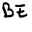

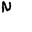

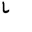

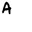

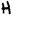

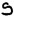

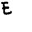

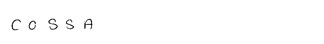

C0
2.0
8$A
1.3333333333333333


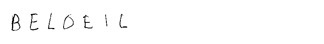

8EL6E|L
0.42857142857142855


Contour Area: 11.5


Contour Area: 4.5


Contour Area: 134.0


Contour Area: 62.5


Contour Area: 2.0


Contour Area: 105.0


Contour Area: 4.0


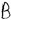

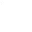

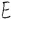

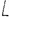

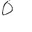

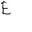

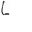

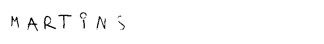

AARTFN>
0.42857142857142855


Contour Area: 34.5


Contour Area: 95.0


Contour Area: 4.0


Contour Area: 91.0


Contour Area: 80.5


Contour Area: 125.0


Contour Area: 92.0


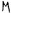

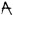

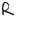

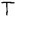

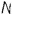

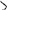

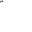

DRENOM
1.0
RAYANE
0.0


Contour Area: 123.0


Contour Area: 4.0


Contour Area: 3.0


Contour Area: 115.5


Contour Area: 203.5


Contour Area: 98.5


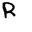

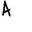

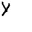

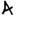

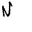

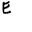

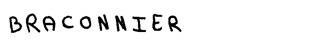

BRACONNIER
0.0


Contour Area: 10.0


Contour Area: 162.0


Contour Area: 186.0


Contour Area: 170.0


Contour Area: 158.0


Contour Area: 122.0


Contour Area: 9.0


Contour Area: 206.0


Contour Area: 170.5


Contour Area: 5.5


Contour Area: 9.5


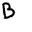

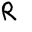

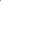

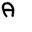

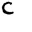

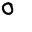

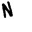

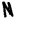

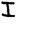

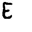

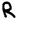

BRENOM:
1.0
ANDREA
0.0


Contour Area: 12.0


Contour Area: 137.5


Contour Area: 4.0


Contour Area: 4.5


Contour Area: 7.5


Contour Area: 6.0


Contour Area: 8.5


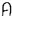

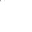

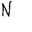

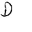

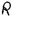

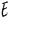

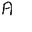

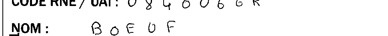

COD
1.3333333333333333
UKI
1.6666666666666667
NOM
1.3333333333333333
0€
2.5


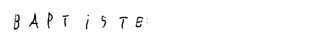

84PTI5TE
0.375


Contour Area: 29.0


Contour Area: 83.5


Contour Area: 63.5


Contour Area: 53.0


Contour Area: 55.5


Contour Area: 83.5


Contour Area: 104.0


Contour Area: 83.0


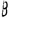

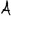

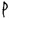

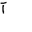

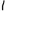

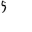

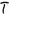

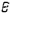

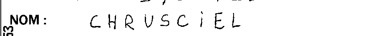

NOM:
2.25
CHRUSC;EL
0.1111111111111111


Contour Area: 24.5


Contour Area: 80.5


Contour Area: 87.0


Contour Area: 90.5


Contour Area: 6.5


Contour Area: 132.5


Contour Area: 3.0


Contour Area: 73.5


Contour Area: 123.5


Contour Area: 4.0


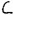

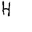

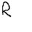

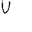

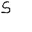

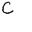

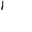

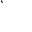

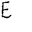

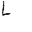

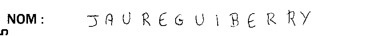

NOM
4.333333333333333
JAUR€GU|B€RRY
0.23076923076923078


Contour Area: 67.0


Contour Area: 4.0


Contour Area: 83.0


Contour Area: 86.0


Contour Area: 87.5


Contour Area: 9.5


Contour Area: 91.0


Contour Area: 102.5


Contour Area: 74.5


Contour Area: 99.0


Contour Area: 3.0


Contour Area: 95.0


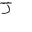

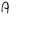

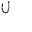

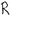

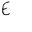

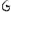

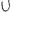

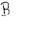

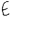

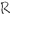

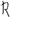

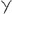

SA1)AN
0.5


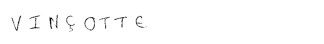

VIMCOTT€
0.25


Contour Area: 4.5


Contour Area: 3.0


Contour Area: 2.0


Contour Area: 46.0


Contour Area: 57.0


Contour Area: 2.0


Contour Area: 4.0


Contour Area: 3.0


Contour Area: 3.0


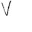

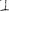

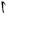

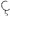

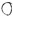

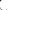

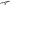

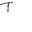

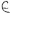

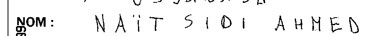

8OM:
3.5
NA'IT
2.4
5|0|
3.75
4HNEA
2.6


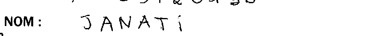

NOM
1.6666666666666667
JANAT
0.2


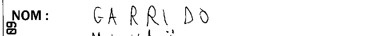

NOM:
1.75
GARRI$O
0.14285714285714285


Contour Area: 49.0


Contour Area: 119.5


Contour Area: 5.0


Contour Area: 145.5


Contour Area: 5.0


Contour Area: 184.0


Contour Area: 136.5


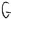

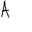

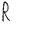

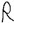

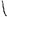

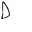

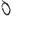

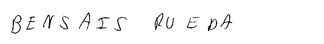

BE^$AIJ
1.2857142857142858
QUEPA
2.0


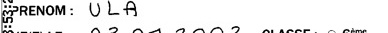

RENOM
1.0
ULA
0.0
6
3.0


Contour Area: 4.0


Contour Area: 111.5


Contour Area: 6.5


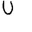

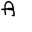

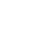

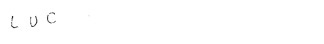

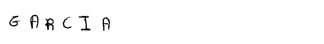

9R€IA
0.6


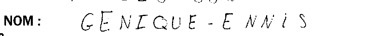

NOM
4.0
CENICUE
1.1428571428571428
ENNI$
1.8


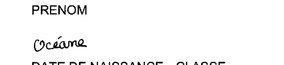

PRENOM
0.8333333333333334
CCIAME
0.5


Contour Area: 19.0


Contour Area: 11.5


Contour Area: 5.5


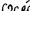

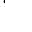

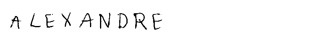

1LEXANDRE
0.1111111111111111


Contour Area: 8.0


Contour Area: 68.0


Contour Area: 110.0


Contour Area: 4.5


Contour Area: 117.5


Contour Area: 7.5


Contour Area: 5.5


Contour Area: 185.5


Contour Area: 158.5


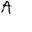

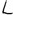

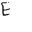

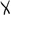

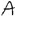

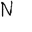

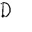

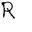

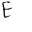

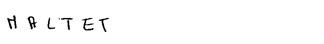

10LTET
0.3333333333333333


Contour Area: 62.0


Contour Area: 81.5


Contour Area: 4.0


Contour Area: 90.5


Contour Area: 108.5


Contour Area: 118.5


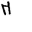

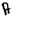

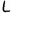

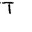

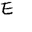

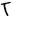

PEREZ
0.0


Contour Area: 6.0


Contour Area: 126.0


Contour Area: 145.0


Contour Area: 131.5


Contour Area: 142.0


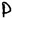

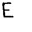

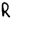

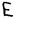

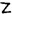

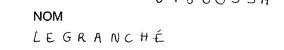

NOM
2.6666666666666665
LE6RA
1.0
0€#€
2.25


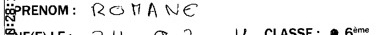

RPRENOM
0.7142857142857143
0O
2.5
N€
2.5
1A
2.5


ANORE
0.2


Contour Area: 2.0


Contour Area: 141.5


Contour Area: 95.5


Contour Area: 96.0


Contour Area: 129.0


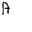

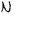

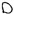

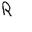

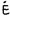

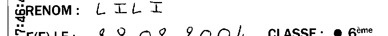

GRENOM:
1.0
LILI
0.0
CCF
1.3333333333333333
GEN
1.3333333333333333


Contour Area: 64.0


Contour Area: 3.0


Contour Area: 97.5


Contour Area: 5.5


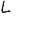

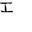

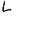

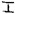

JRENOM
0.8333333333333334
RI€K
0.25


Contour Area: 103.5


Contour Area: 78.0


Contour Area: 110.0


Contour Area: 98.0


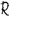

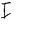

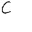

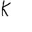

SRENOM:
0.8571428571428571
RLANNE
0.16666666666666666


EWEN
0.0
GRENOM;
0.7142857142857143


Contour Area: 131.5


Contour Area: 4.5


Contour Area: 3.0


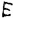

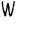

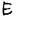

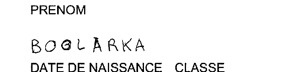

PRENOM
1.3333333333333333
BOG1ARKA
0.125
DATEDENAISSANCE
0.8666666666666667
CLASSE
1.0


Contour Area: 31.0


Contour Area: 84.5


Contour Area: 12.5


Contour Area: 50.5


Contour Area: 115.5


Contour Area: 3.5


Contour Area: 105.5


Contour Area: 143.0


Contour Area: 106.0


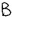

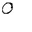

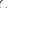

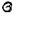

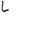

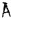

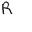

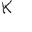

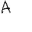

GUST
0.0


Contour Area: 4.0


Contour Area: 74.0


Contour Area: 5.0


Contour Area: 77.5


Contour Area: 2.5


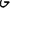

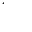

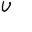

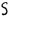

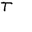

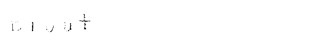

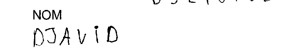

NOM
2.0
DJAVID
0.0


Contour Area: 47.5


Contour Area: 3.0


Contour Area: 120.5


Contour Area: 2.0


Contour Area: 5.0


Contour Area: 197.0


Contour Area: 66.0


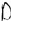

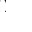

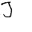

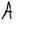

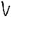

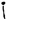

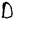

ERENOM=
1.0
HARGAUX
0.14285714285714285


Contour Area: 128.5


Contour Area: 138.5


Contour Area: 175.5


Contour Area: 5.0


Contour Area: 155.0


Contour Area: 149.0


Contour Area: 3.0


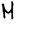

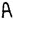

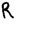

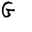

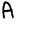

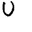

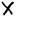

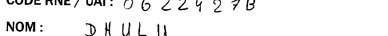

00
2.5
22427B
1.0
NOM:
1.25


CADWAL
0.0


Contour Area: 87.0


Contour Area: 94.0


Contour Area: 122.0


Contour Area: 201.5


Contour Area: 125.5


Contour Area: 5.5


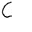

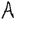

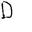

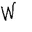

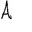

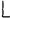

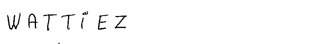

WATTIEZ
0.0


Contour Area: 39.0


Contour Area: 2.0


Contour Area: 113.5


Contour Area: 119.5


Contour Area: 90.5


Contour Area: 5.5


Contour Area: 101.0


Contour Area: 127.0


Contour Area: 26.0


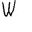

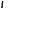

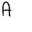

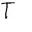

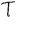

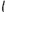

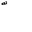

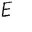

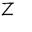

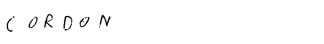

(~0R00N
0.7142857142857143


#RENOM
0.8333333333333334
0FNT)N
0.6666666666666666


RAXAN
0.2


Contour Area: 93.0


Contour Area: 67.5


Contour Area: 84.0


Contour Area: 2.0


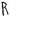

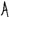

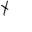

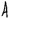

SRENOM:
0.8571428571428571
THOHA$
0.3333333333333333


Contour Area: 143.0


Contour Area: 5.0


Contour Area: 89.5


Contour Area: 94.0


Contour Area: 105.5


Contour Area: 96.0


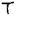

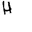

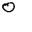

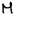

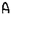

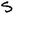

CUCHERIL
0.0


Contour Area: 31.0


Contour Area: 76.5


Contour Area: 78.5


Contour Area: 71.5


Contour Area: 96.0


Contour Area: 72.0


Contour Area: 72.5


Contour Area: 14.0


Contour Area: 109.5


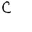

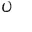

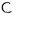

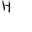

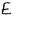

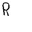

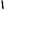

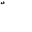

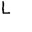

RRENOM
1.0
L0UIS
0.2


Contour Area: 141.0


Contour Area: 113.0


Contour Area: 100.0


Contour Area: 4.5


Contour Area: 3.0


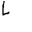

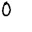

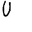

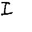

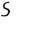

PPRENOM:
0.875
EL
1.5
N€
2.0


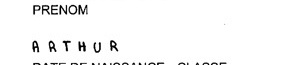

PRENOM
0.8333333333333334
ARTHUR
0.0


Contour Area: 95.5


Contour Area: 92.0


Contour Area: 7.0


Contour Area: 4.0


Contour Area: 2.0


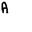

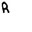

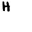

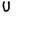

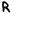

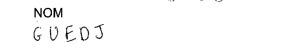

NOM
1.6666666666666667
G0EDJ
0.2


Contour Area: 92.0


Contour Area: 140.5


Contour Area: 8.5


Contour Area: 110.5


Contour Area: 87.5


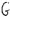

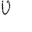

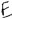

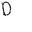

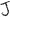

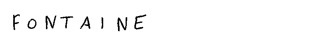

F0NTA|NE
0.25


Contour Area: 107.0


Contour Area: 4.5


Contour Area: 37.0


Contour Area: 90.5


Contour Area: 87.0


Contour Area: 4.0


Contour Area: 3.5


Contour Area: 91.5


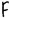

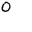

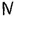

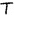

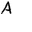

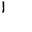

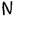

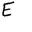

SIHEON
0.16666666666666666


Contour Area: 143.0


Contour Area: 123.5


Contour Area: 3.0


Contour Area: 8.0


Contour Area: 5.0


Contour Area: 68.0


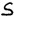

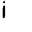

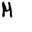

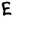

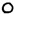

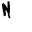

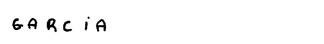

60RCIA
0.3333333333333333


Contour Area: 92.0


Contour Area: 127.5


Contour Area: 137.5


Contour Area: 115.5


Contour Area: 122.5


Contour Area: 48.5


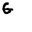

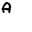

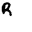

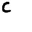

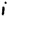

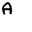

LE6R
1.0
AND
1.3333333333333333


C0RENTIN
0.125


Contour Area: 4.5


Contour Area: 3.0


Contour Area: 105.0


Contour Area: 117.0


Contour Area: 7.5


Contour Area: 70.0


Contour Area: 4.0


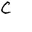

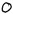

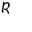

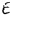

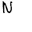

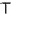

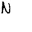

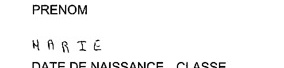

PRENOM
1.0
4ARI€
0.4
DTCCCNCCANCF
0.9166666666666666
AACC
1.0


Contour Area: 82.5


Contour Area: 67.5


Contour Area: 72.0


Contour Area: 70.5


Contour Area: 72.5


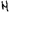

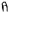

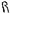

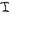

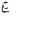

V^TH
0.75


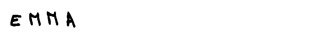

EMNA
0.25


Contour Area: 139.5


Contour Area: 143.5


Contour Area: 123.0


Contour Area: 2.5


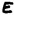

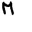

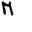

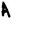

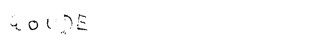

10(22
1.0


Contour Area: 9.0


Contour Area: 39.0


Contour Area: 41.5


Contour Area: 103.5


Contour Area: 36.5


Contour Area: 53.0


Contour Area: 3.0


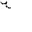

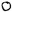

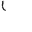

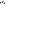

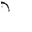

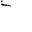

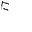

RENOM
1.6
C#ARLOTTE
0.1111111111111111


Contour Area: 67.5


Contour Area: 96.0


Contour Area: 145.5


Contour Area: 2.5


Contour Area: 80.5


Contour Area: 75.5


Contour Area: 129.0


Contour Area: 3.0


Contour Area: 90.5


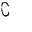

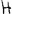

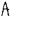

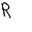

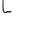

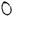

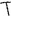

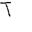

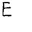

RRENOM:
1.0
CAMILLE
0.0


Contour Area: 36.5


Contour Area: 74.0


Contour Area: 70.0


Contour Area: 78.5


Contour Area: 2.5


Contour Area: 130.0


Contour Area: 3.5


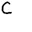

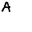

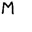

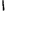

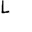

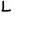

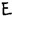

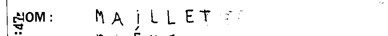

EOM
2.3333333333333335
MAJ[LET
0.2857142857142857


Contour Area: 102.0


Contour Area: 72.0


Contour Area: 64.0


Contour Area: 2.0


Contour Area: 83.0


Contour Area: 5.0


Contour Area: 7.5


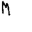

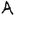

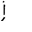

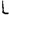

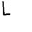

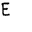

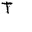

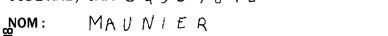

CNOM
1.5
MAUN/ER
0.14285714285714285


Contour Area: 31.5


Contour Area: 115.5


Contour Area: 3.0


Contour Area: 7.0


Contour Area: 4.5


Contour Area: 153.5


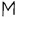

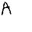

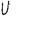

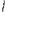

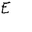

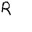

RRENOM
0.8333333333333334
RE0ECC
0.3333333333333333


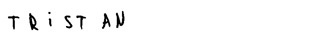

TQIST
0.6
AV
3.0


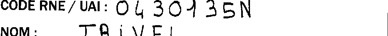

CODERNE_
0.875
UAI:0430435N
0.8333333333333334
NOM
2.0


RENOM
1.0
#ENTAMIN
0.25


Contour Area: 3.0


Contour Area: 146.0


Contour Area: 149.0


Contour Area: 146.0


Contour Area: 144.0


Contour Area: 68.5


Contour Area: 131.0


Contour Area: 219.5


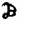

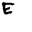

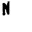

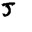

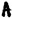

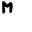

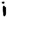

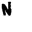

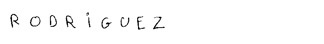

0RI60E2
0.8571428571428571


6ILL
0.5


PIBOURRET
0.0


Contour Area: 6.5


Contour Area: 4.0


Contour Area: 85.0


Contour Area: 135.5


Contour Area: 122.5


Contour Area: 116.0


Contour Area: 128.0


Contour Area: 3.0


Contour Area: 4.5


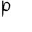

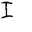

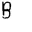

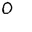

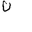

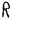

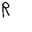

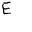

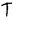

HASII
0.4


Contour Area: 110.5


Contour Area: 104.5


Contour Area: 105.0


Contour Area: 105.5


Contour Area: 93.0


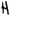

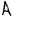

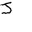

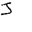

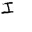

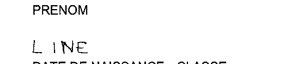

PRENOM
0.8333333333333334
LINE
0.0


Contour Area: 31.5


Contour Area: 3.5


Contour Area: 8.5


Contour Area: 63.5


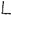

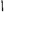

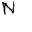

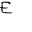

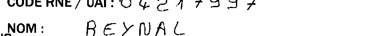

JODC
1.5
UAI=
1.5
0+0"T3=
1.0
NOM
1.6666666666666667
R€Y0A
0.6


{PRENOM
1.0


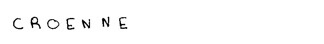

CA0ENNE
0.2857142857142857


Contour Area: 4.0


Contour Area: 2.5


Contour Area: 129.0


Contour Area: 91.5


Contour Area: 77.5


Contour Area: 93.5


Contour Area: 84.5


Contour Area: 7.0


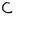

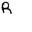

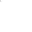

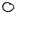

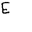

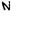

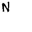

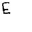

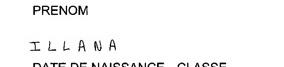

PRENOM
1.0
ILLAWA
0.16666666666666666


Contour Area: 3.5


Contour Area: 51.0


Contour Area: 88.0


Contour Area: 79.0


Contour Area: 3.0


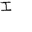

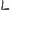

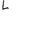

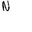

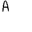

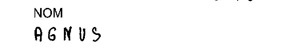

NOM
1.3333333333333333
AGNV$
0.4


Contour Area: 105.5


Contour Area: 106.5


Contour Area: 122.5


Contour Area: 7.0


Contour Area: 130.0


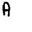

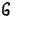

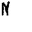

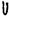

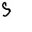

BPRENOM
1.0
0N4
2.0


In [15]:
characters_obtained2, letters_obtained2 = obtain_train_data('train_names_paths_reduced2.xlsx')

In [16]:
def flatten_letters(samples):
    return samples.reshape((len(samples), 15*15))

In [17]:
#np.array(letters_obtained2)
letters = letters_obtained2
resized_letters = np.empty([len(letters), 15, 15])
resized_letters = list(resized_letters)

for i in range(len(resized_letters)):
    resized_letters[i] = list(cv2.resize(np.copy(letters[i]), (15, 15)))

resized_letters = np.asarray(resized_letters)
flattened_letters = flatten_letters(resized_letters)

In [18]:
one_hot_list = []
alphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
for i in range(len(characters_obtained2)):
  one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  j = alphabet.index(characters_obtained2[i])
  one_hot[j] = 1
  one_hot_list.append(one_hot)

In [19]:
for i in range(len(characters_obtained2)):
  print(characters_obtained2[i])
  cv2_imshow(letters_obtained2[i])

B


A


L


T


H


A


Z


A


R


S


I


M


O


N


B


E


N


E


S


E


L


I


S


E


M


A


T


H


E


O


R


O


M


A


I


N


L


I


L


O


U


M


I


T


H


I


E


U


X


M


A


R


I


O


N


T


H


O


M


A


S


A


N


A


I


S


J


A


F


F


E


U


X


A


N


N


E


P


R


E


V


O


S


T


B


R


U


G


E


R


I


E


N


O


L


A


N


F


R


A


N


C


O


I


S


M


E


I


S


S


A


A


M


B


R


O


I


S


E


B


E


N


Z


I


N


A


Y


A


E


L


M


A


T


H


E


O


J


U


L


I


E


B


A


R


B


I


E


R


D


U


P


R


A


T


L


A


B


A


R


H


I


N


E


S


C


R


O


C


H


A


R


D


F


R


E


D


E


R


I


C


R


O


D


R


I


G


U


E


S


A


N


T


O


I


N


E


J


U


L


I


E


P


E


R


I


O


L


G


A


R


G


U


E


B


A


S


H


L


E


Y


N


O


U


R


T


H


E


O


V


I


N


C


E


N


T


L


O


V


I


S


V


E


R


S


T


R


A


E


T


E


S


I


N


D


I


E


M


M


A


D


E


R


V


A


U


X


G


U


I


L


L


O


C


O


L


L


I


N


B


O


U


T


E


T


B


E


R


N


A


R


D


B


E


L


O


E


I


L


M


A


R


T


I


N


S


R


A


Y


A


N


E


B


A


P


T


I


S


T


E


G


A


R


R


I


D


O


U


L


A


A


L


E


X


A


N


D


R


E


M


A


L


T


E


T


P


E


R


E


Z


A


N


D


R


E


L


I


L


I


R


I


C


K


M


A


R


G


A


U


X


C


A


D


W


A


L


T


H


O


M


A


S


L


O


U


I


S


G


U


E


D


J


F


O


N


T


A


I


N


E


S


I


M


E


O


N


G


A


R


C


I


A


M


A


R


I


E


E


M


M


A


C


H


A


R


L


O


T


T


E


C


A


M


I


L


L


E


M


A


I


L


L


E


T


B


E


N


J


A


M


I


N


P


I


B


O


U


R


R


E


T


H


A


J


J


I


L


I


N


E


A


G


N


U


S


In [27]:
model = keras.Sequential(
    [
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(26, activation="softmax"),
    ]
)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
X_train = flattened_letters
y_train = characters_obtained2
y_train = np.asarray(one_hot_list)

model.fit(X_train, y_train, batch_size=100, epochs=50, verbose=1)

Epoch 1/50
5/5 [==============================] - 1s 2ms/step - loss: 159.5727 - accuracy: 0.0570
Epoch 2/50
5/5 [==============================] - 0s 2ms/step - loss: 92.3923 - accuracy: 0.0527
Epoch 3/50
5/5 [==============================] - 0s 2ms/step - loss: 68.2454 - accuracy: 0.0295
Epoch 4/50
5/5 [==============================] - 0s 2ms/step - loss: 55.3852 - accuracy: 0.0443
Epoch 5/50
5/5 [==============================] - 0s 2ms/step - loss: 45.4030 - accuracy: 0.0675
Epoch 6/50
5/5 [==============================] - 0s 2ms/step - loss: 37.3580 - accuracy: 0.0675
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 31.3136 - accuracy: 0.0717
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 27.8785 - accuracy: 0.1181
Epoch 9/50
5/5 [==============================] - 0s 2ms/step - loss: 25.8717 - accuracy: 0.1203
Epoch 10/50
5/5 [==============================] - 0s 2ms/step - loss: 23.1530 - accuracy: 0.1414
Epoch 11/50
5/5 [===========

In [28]:
predicted_y = model.predict(X_train)
print(predicted_y[0])
max_indices = tf.argmax(predicted_y, axis = 1)
for idx in max_indices:
  print(alphabet[idx])

15/15 [==============================] - 0s 1ms/step
[1.5527369e-01 9.2294082e-02 7.9130225e-02 1.7948553e-04 1.7211091e-03
 2.4450291e-03 4.1633632e-02 1.2354444e-03 8.1416339e-02 2.9364310e-03
 4.8947986e-04 7.4747265e-03 1.0615791e-02 8.9611963e-04 9.2382699e-02
 1.2191542e-02 1.5490110e-03 3.1745139e-01 1.3528242e-03 5.2954927e-03
 2.5806201e-03 5.2099914e-04 8.6072367e-05 1.4191050e-04 2.2404486e-02
 6.6301353e-02]
R
A
T
U
M
I
I
T
X
E
I
T
T
N
R
T
M
T
N
E
C
T
B
E
R
R
N
U
T
T
A
O
A
T
I
B
X
T
I
B
E
M
I
C
R
I
R
U
I
N
R
R
I
R
R
A
N
T
W
A
E
A
E
A
I
S
T
A
T
A
N
T
A
R
N
E
E
R
T
T
U
T
S
T
R
T
N
R
D
X
A
E
N
T
E
T
E
E
A
A
N
A
T
I
C
T
E
T
E
T
A
M
T
R
T
I
T
S
T
E
T
T
T
I
I
L
T
A
B
T
M
A
A
T
T
E
S
U
T
I
E
B
T
A
A
E
N
K
T
T
P
R
A
A
D
T
E
A
G
A
T
T
C
N
Z
R
B
C
M
A
R
M
T
R
T
T
E
A
I
E
E
T
T
B
T
I
I
T
T
A
E
E
Y
T
E
E
E
D
T
S
T
E
E
R
T
O
T
J
A
R
M
T
E
T
A
B
M
B
P
T
N
B
U
T
N
M
R
E
R
I
A
T
U
T
R
S
A
U
T
S
U
E
R
E
A
A
A
L
T
T
S
I
T
E
E
E
M
M
R
S
E
Y
M
R
M
I
S
T
I
E
D
E
D
O
E
E
T
T
S
M
U
T
E
O
I
E
O
T


In [30]:
model.evaluate(X_train,y_train)

15/15 [==============================] - 0s 1ms/step - loss: 2.7450 - accuracy: 0.2954


[2.7449779510498047, 0.29535865783691406]

Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
import statistics

rf = RFC(n_estimators=10, max_depth=10)
rf = rf.fit(train_X, train_y)
print(rf.score(train_X, train_y))
#print(rf.score(test_X, test_y))

In [ ]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
